In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

In [2]:
pd.options.display.float_format = '{:.6f}'.format

In [3]:
DATA_DIM = 784
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(np.int64), X.reshape(-1, DATA_DIM).astype(np.float32)
X = X / 128 - 1

# Noise scheduler

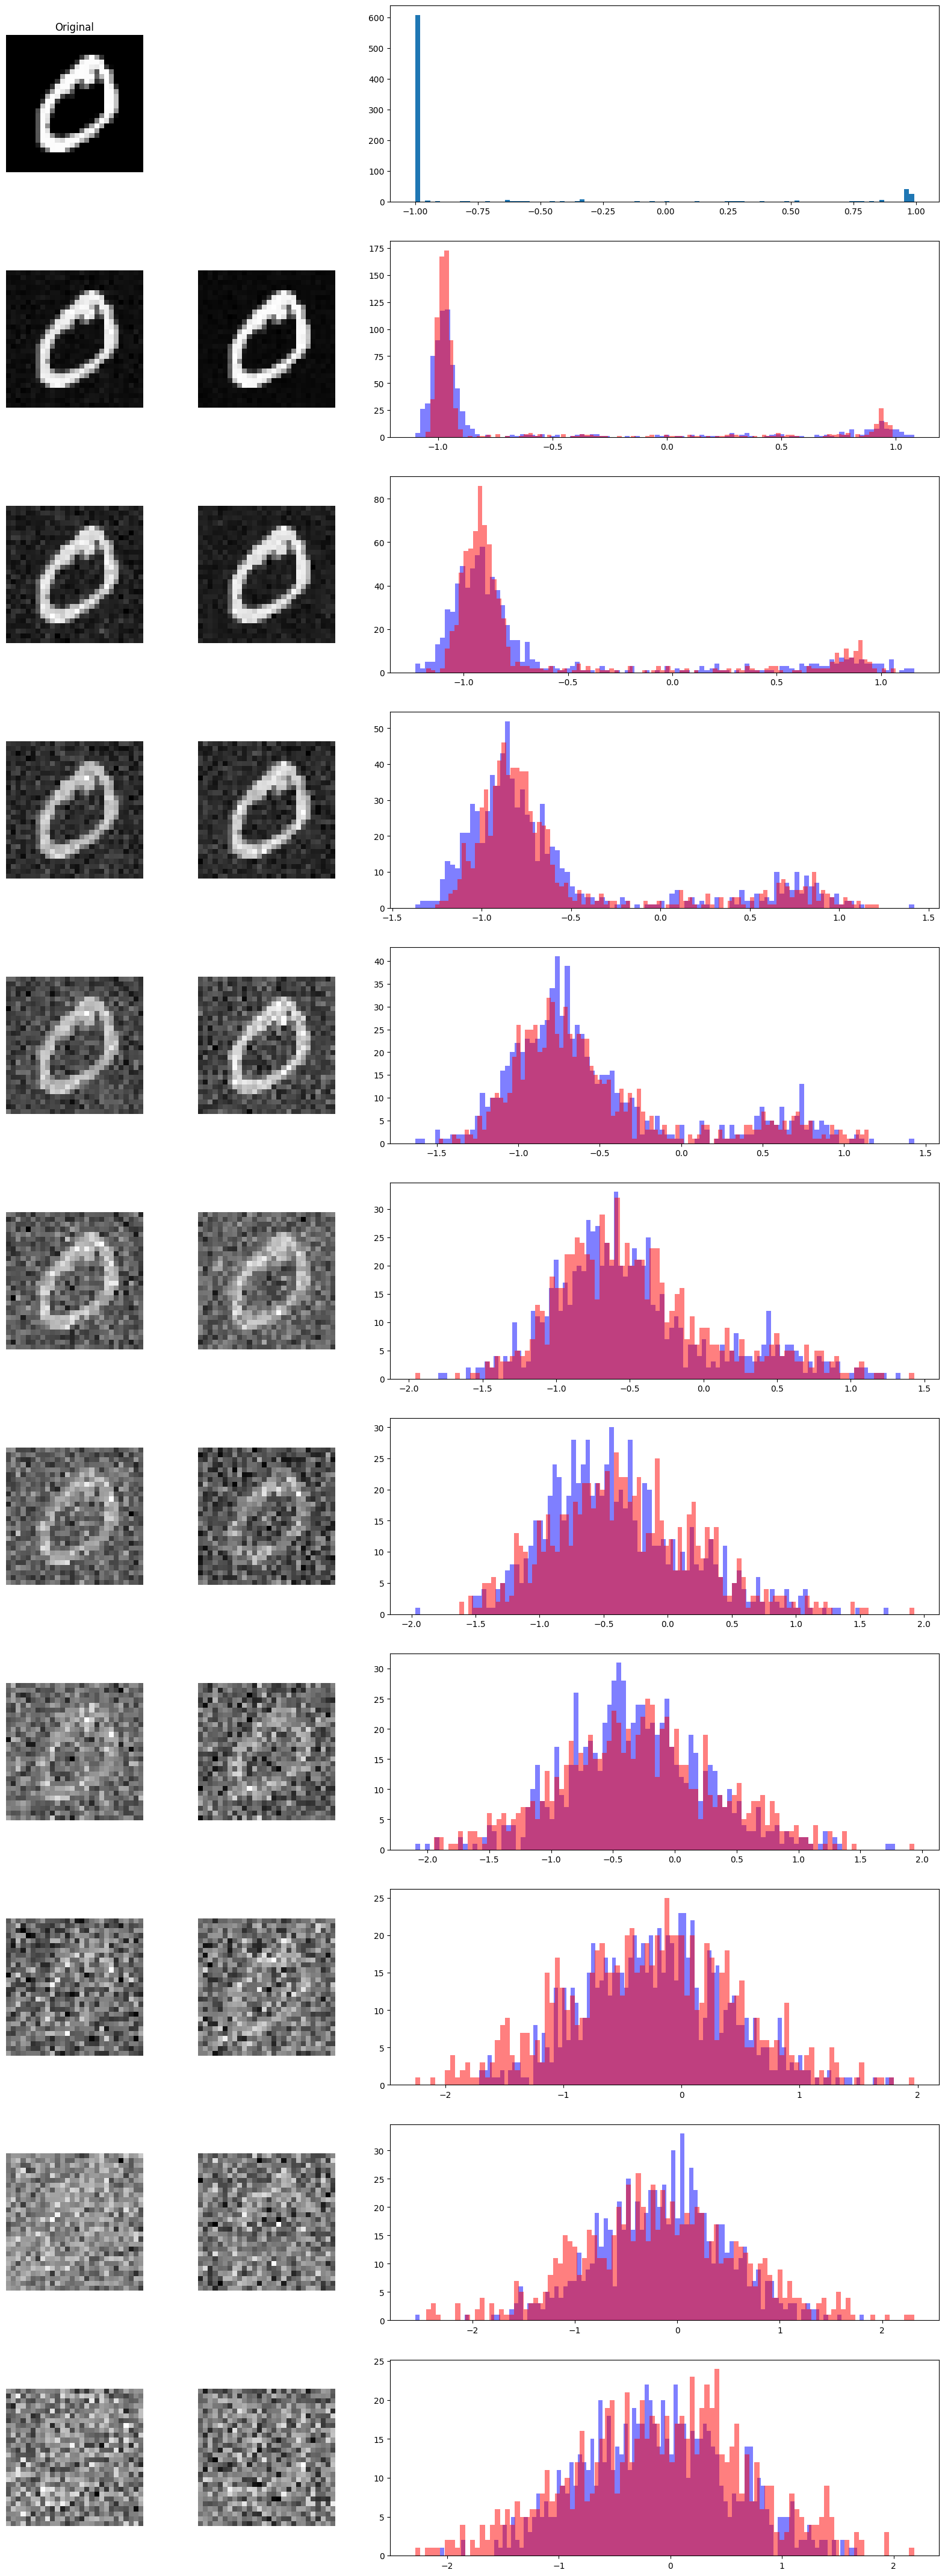

In [4]:
STEPS = 10
BASE_NOISE = 0.05
NOISE = np.array(list(map(lambda x: x * BASE_NOISE, np.arange(1, STEPS + 1))))  # Linear
# NOISE = np.array(list(map(lambda x: BASE_NOISE, np.arange(1, STEPS + 1))))  # Constant
BINS = 100
CLASSES = 10

alphas = np.array(list(map(lambda x: 1 - x, NOISE)))
alpha_prod = np.cumprod(alphas)
original = X[1]


fig = plt.figure(figsize=(20, 5*(STEPS + 1)))
axes = fig.subplots(STEPS + 1, 3, width_ratios=[1, 1, 4])
axes[0, 0].imshow(original.reshape(28, 28), cmap='gray')
axes[0, 2].hist(original, bins=BINS)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')
axes[0, 1].axis('off')

noised = original.copy()
for i in range(STEPS):
	beta = NOISE[i]
	noised = np.random.normal(np.sqrt(1 - beta) * noised, beta, size=noised.shape)
	axes[i + 1, 0].imshow(noised.reshape(28, 28), cmap='gray')
	axes[i + 1, 0].axis('off')
	
	alpha = alpha_prod[i]
	# direct_noised = np.random.normal(np.sqrt(alpha) * original, 1 - alpha, size=original.shape)
	direct_noised = np.random.normal(np.sqrt(alpha) * original, 1 - np.sqrt(alpha), size=original.shape)  # looks better for this distribution of data
	axes[i + 1, 1].imshow(direct_noised.reshape(28, 28), cmap='gray')
	axes[i + 1, 1].axis('off')
	
	axes[i + 1, 2].hist(noised, bins=BINS, alpha=0.5, color='blue', label='Noised')
	axes[i + 1, 2].hist(direct_noised, bins=BINS, alpha=0.5, color='red', label='Direct noised')

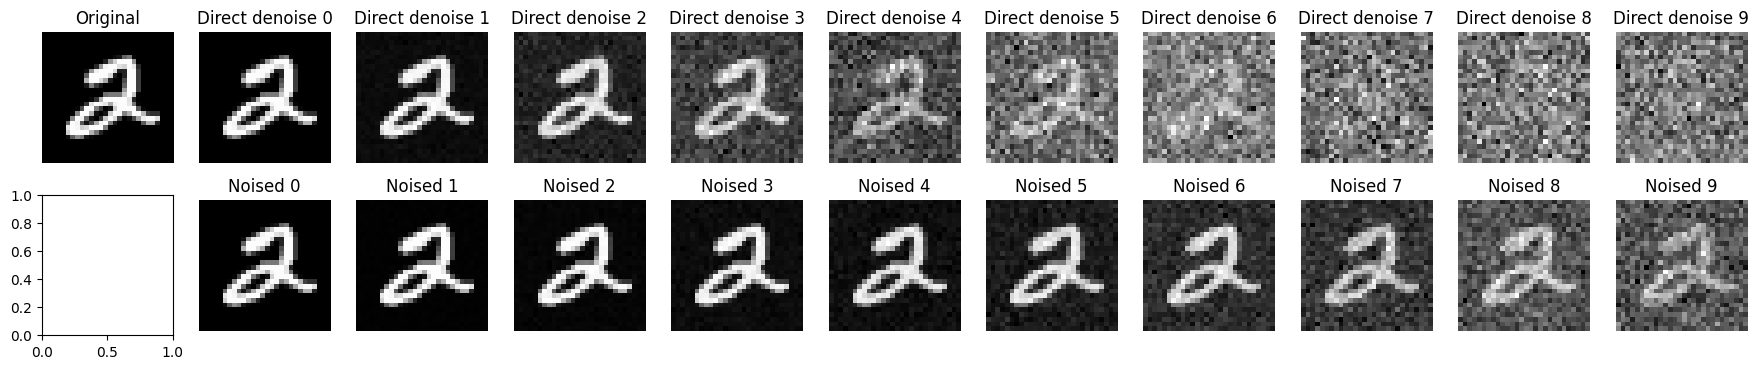

In [5]:
STEPS = 1000
BASE_NOISE = 0.00001
NOISE = torch.tensor(list(map(lambda x: x * BASE_NOISE, torch.arange(1, STEPS + 1))))

alphas = 1 - NOISE
alpha_prod = torch.cumprod(alphas, dim=0)
alpha_prev = torch.nn.functional.pad(alpha_prod[:-1], (1, 0), value=1.0)
alpha_sqrt = torch.sqrt(1. / alphas)
alpha_sqrt_prod = torch.cumprod(alpha_sqrt, dim=0)
one_minus_alpha = torch.sqrt(1. - alpha_prod)
posterior_variance = NOISE * (1. - alpha_prev) / (1. - alpha_prod)

@torch.no_grad()
def make_backward_step(image, t, prediction):
	broadcast = lambda x: x.reshape(*t.shape, 1).expand(*t.shape, image.shape[1])
	beta_t = NOISE[t]
	one_minus_alpha_t = one_minus_alpha[t]
	alpha_sqrt_t = alpha_sqrt[t]
	posterior_t = broadcast(posterior_variance[t])
	model_mean = broadcast(alpha_sqrt_t) * (
		image - broadcast(beta_t) * prediction / broadcast(one_minus_alpha_t)
	)
	noise = torch.randn(model_mean.shape)
	not_zero_index = torch.argwhere(t != 0)
	model_mean[not_zero_index] += torch.sqrt(posterior_t[not_zero_index]) * noise[not_zero_index]
	return model_mean


def denoise_step(image, t):
	beta = NOISE[t]
	return torch.randn(image.shape) * beta + torch.sqrt(1 - beta) * image

def denoise_direct(original, t):
	alpha = alpha_prod[t]
	s = torch.sqrt(alpha)
	s_reshaped = s.reshape(s.shape[0], 1).expand(original.shape)
	return torch.randn(original.shape) * (1 - s_reshaped) + s_reshaped * original

original = torch.from_numpy(X[5])
noised = original.clone().repeat(10, 1)
for i in range(10):
	for j in range(i * STEPS // 10):
		noised[i] = denoise_step(noised[i], j)
direct_denoise = denoise_direct(original.reshape(1, 784).broadcast_to(10, 784), torch.arange(0, STEPS, STEPS // 10))

figure = plt.figure(figsize=(2 * 11, 2*2))
axes = figure.subplots(2, 11).flatten()
axes[0].imshow(original.reshape(28, 28), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i in range(10):
	axes[i + 1].imshow(direct_denoise[i].reshape(28, 28), cmap='gray')
	axes[i + 1].set_title(f'Direct denoise {i}')
	axes[i + 1].axis('off')
	axes[i + 10 + 2].imshow(noised[i].reshape(28, 28), cmap='gray')
	axes[i + 10 + 2].set_title(f'Noised {i}')
	axes[i + 10 + 2].axis('off')

# Timestep encoding

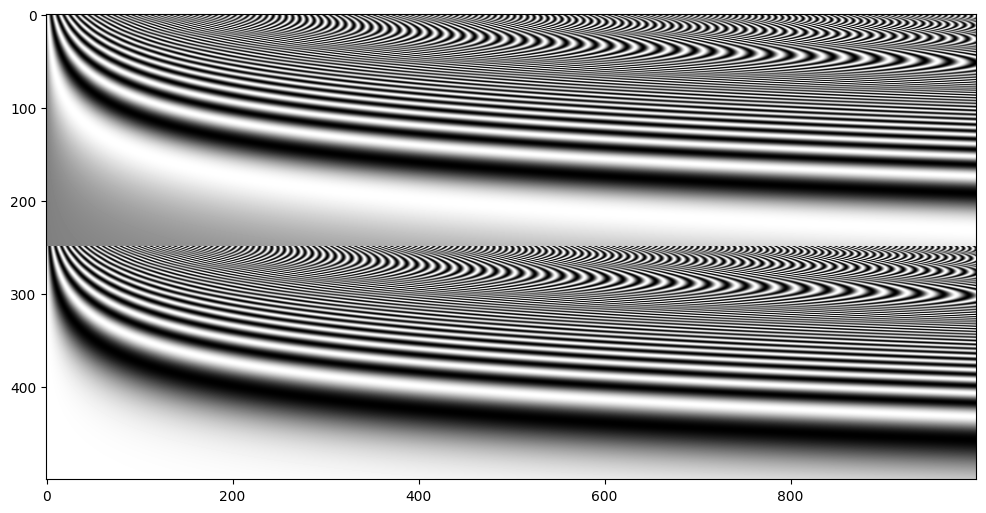

In [6]:
ENCODE_DIM = 500
half_dim = ENCODE_DIM // 2
delimiters = torch.pow(STEPS, torch.arange(1, half_dim + 1) / half_dim)

def encode_timestep(t):
	embeddings = t[:, None] / delimiters[None, :]
	return torch.cat([
		torch.sin(embeddings), 
		torch.cos(embeddings)
	], dim=1)

with torch.no_grad():
	encoded = encode_timestep(torch.arange(0, STEPS)).numpy()
	plt.figure(figsize=(12,8))
	plt.imshow(encoded.T, cmap='gray')
	plt.show()

# Model

In [7]:
class StableDiffusion(torch.nn.Module):
	def __init__(self):
		super(StableDiffusion, self).__init__()
		self.first = torch.nn.Linear(DATA_DIM + CLASSES + ENCODE_DIM, 100)
		self.first_dropout = torch.nn.Dropout(0.5)
		self.second = torch.nn.Linear(100, 1000)
		self.second_dropout = torch.nn.Dropout(0.5)
		self.third = torch.nn.Linear(1000, DATA_DIM)
		
	def forward(self, x, t, classes):
		with torch.no_grad():
			classes_sample = torch.nn.functional.one_hot(classes, num_classes=CLASSES)
			encoded_timestep = encode_timestep(t)
			x = torch.cat([x, classes_sample, encoded_timestep], dim=1)
		x = self.first(x)
		x = torch.nn.functional.relu(x)
		x = self.first_dropout(x)
		x = self.second(x)
		x = torch.nn.functional.relu(x)
		x = self.second_dropout(x)
		x = self.third(x)
		return x
	
sd = StableDiffusion()
print(f"{sum(p.numel() for p in sd.parameters()):_}")
print(sd)

1_015_284
StableDiffusion(
  (first): Linear(in_features=1294, out_features=100, bias=True)
  (first_dropout): Dropout(p=0.5, inplace=False)
  (second): Linear(in_features=100, out_features=1000, bias=True)
  (second_dropout): Dropout(p=0.5, inplace=False)
  (third): Linear(in_features=1000, out_features=784, bias=True)
)


In [8]:
EPOCHS = 500
BATCH_SIZE = 100

train_data = torch.from_numpy(X)
train_labels = torch.from_numpy(y)
optimizer = torch.optim.Adam(sd.parameters(), lr=0.001)
lossFn = torch.nn.L1Loss()
losses = []

sd.train()

for i in progressbar(range(EPOCHS)):
	loss_agg = 0
	permutation = torch.randperm(train_data.size()[0])
	for j in range(0, train_data.size()[0], BATCH_SIZE):
		
		with torch.no_grad():
			indices = permutation[j:j + BATCH_SIZE]
			batch = train_data[indices]
			classes = train_labels[indices]
			timestamps = torch.randint(0, STEPS, size=(BATCH_SIZE,))
			noised = denoise_direct(batch, timestamps)
			noise = batch - noised
		optimizer.zero_grad()
		pred = sd(noised, timestamps, classes)
		loss = lossFn(pred, noise)
		loss.backward()
		optimizer.step()
		loss_agg += loss.item()
	losses.append(loss_agg)

100% (500 of 500) |######################| Elapsed Time: 1:26:21 Time:  1:26:215105


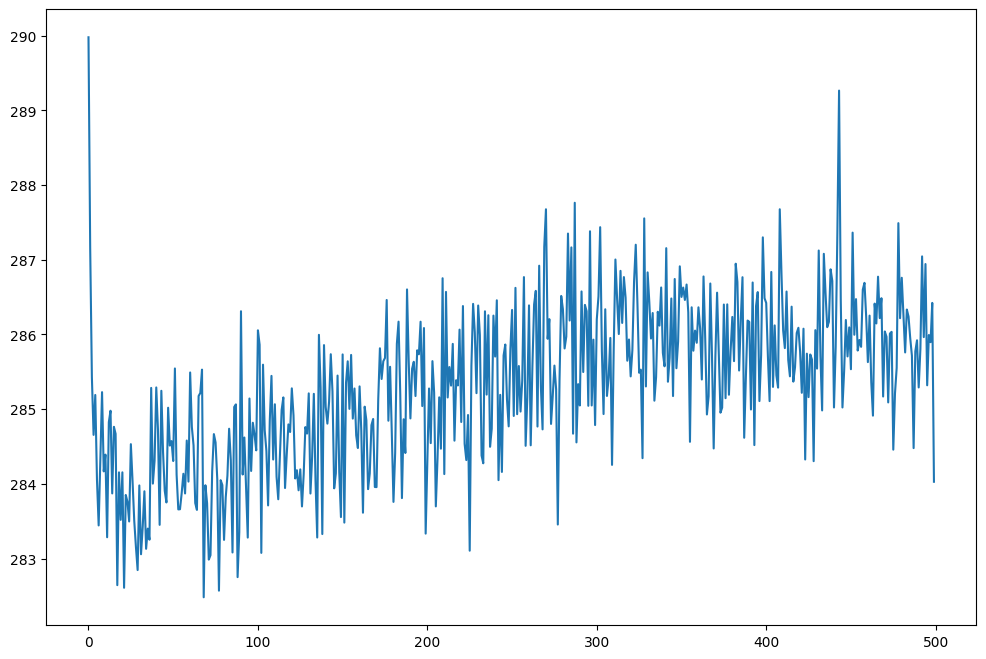

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(losses)

In [10]:
torch.save(sd.state_dict(), 'stable-diffusion.pth')

In [11]:
sd.load_state_dict(torch.load('stable-diffusion.pth'))

<All keys matched successfully>

# Reconstruction of some samples

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:010000


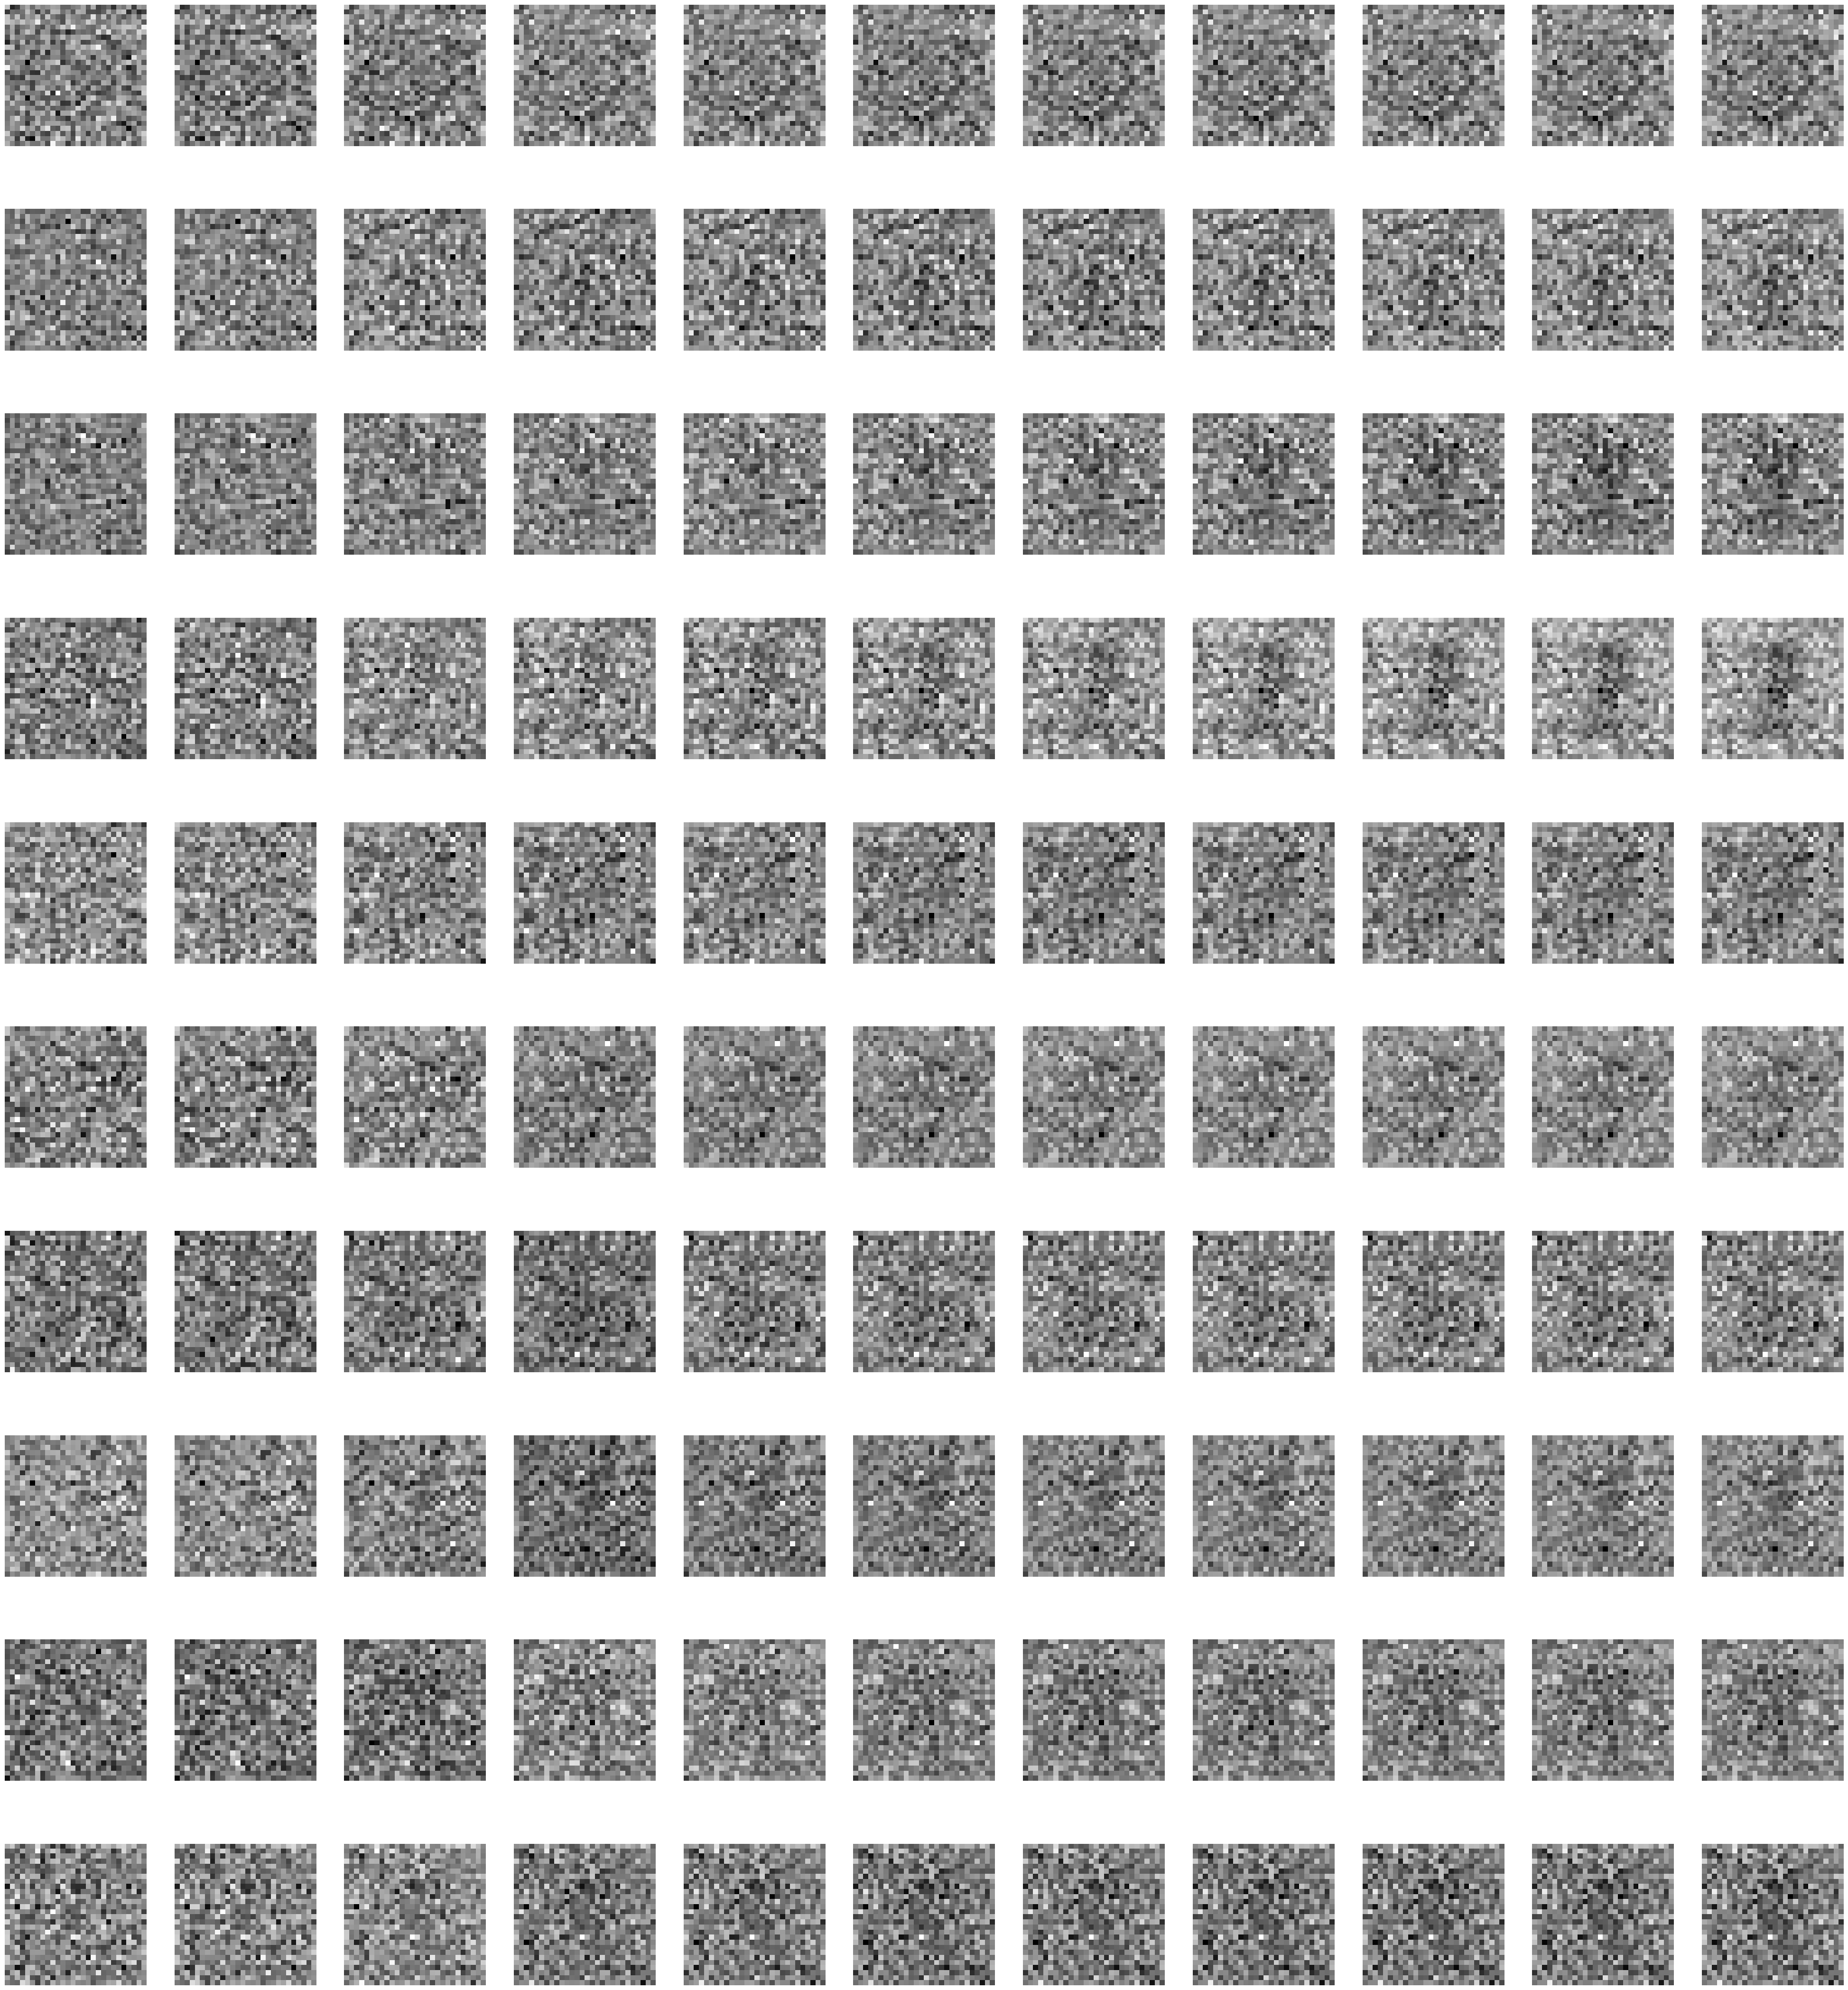

In [12]:
sd.eval()

classes = torch.arange(10)
images = torch.randn(10, DATA_DIM)

fig = plt.figure(figsize=(5 * 10, 5 * 11))
axes = fig.subplots(10, 11)

for i, im in enumerate(images):
	axes[i, 0].imshow(im.reshape(28, 28), cmap='gray')
	axes[i, 0].axis('off')

with torch.no_grad():
	for i in progressbar(range(STEPS)):
		t = STEPS - i - 1
		t_tensor = torch.tensor([t] * 10)
		pred = sd(images, t_tensor, classes)
		images = make_backward_step(images, t_tensor, pred)
		if i % 100 == 0:
			for j, im in enumerate(images):
				axes[j, i // 100 + 1].imshow(im.reshape(28, 28), cmap='gray')
				axes[j, i // 100 + 1].axis('off')
		

100% (994 of 994) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


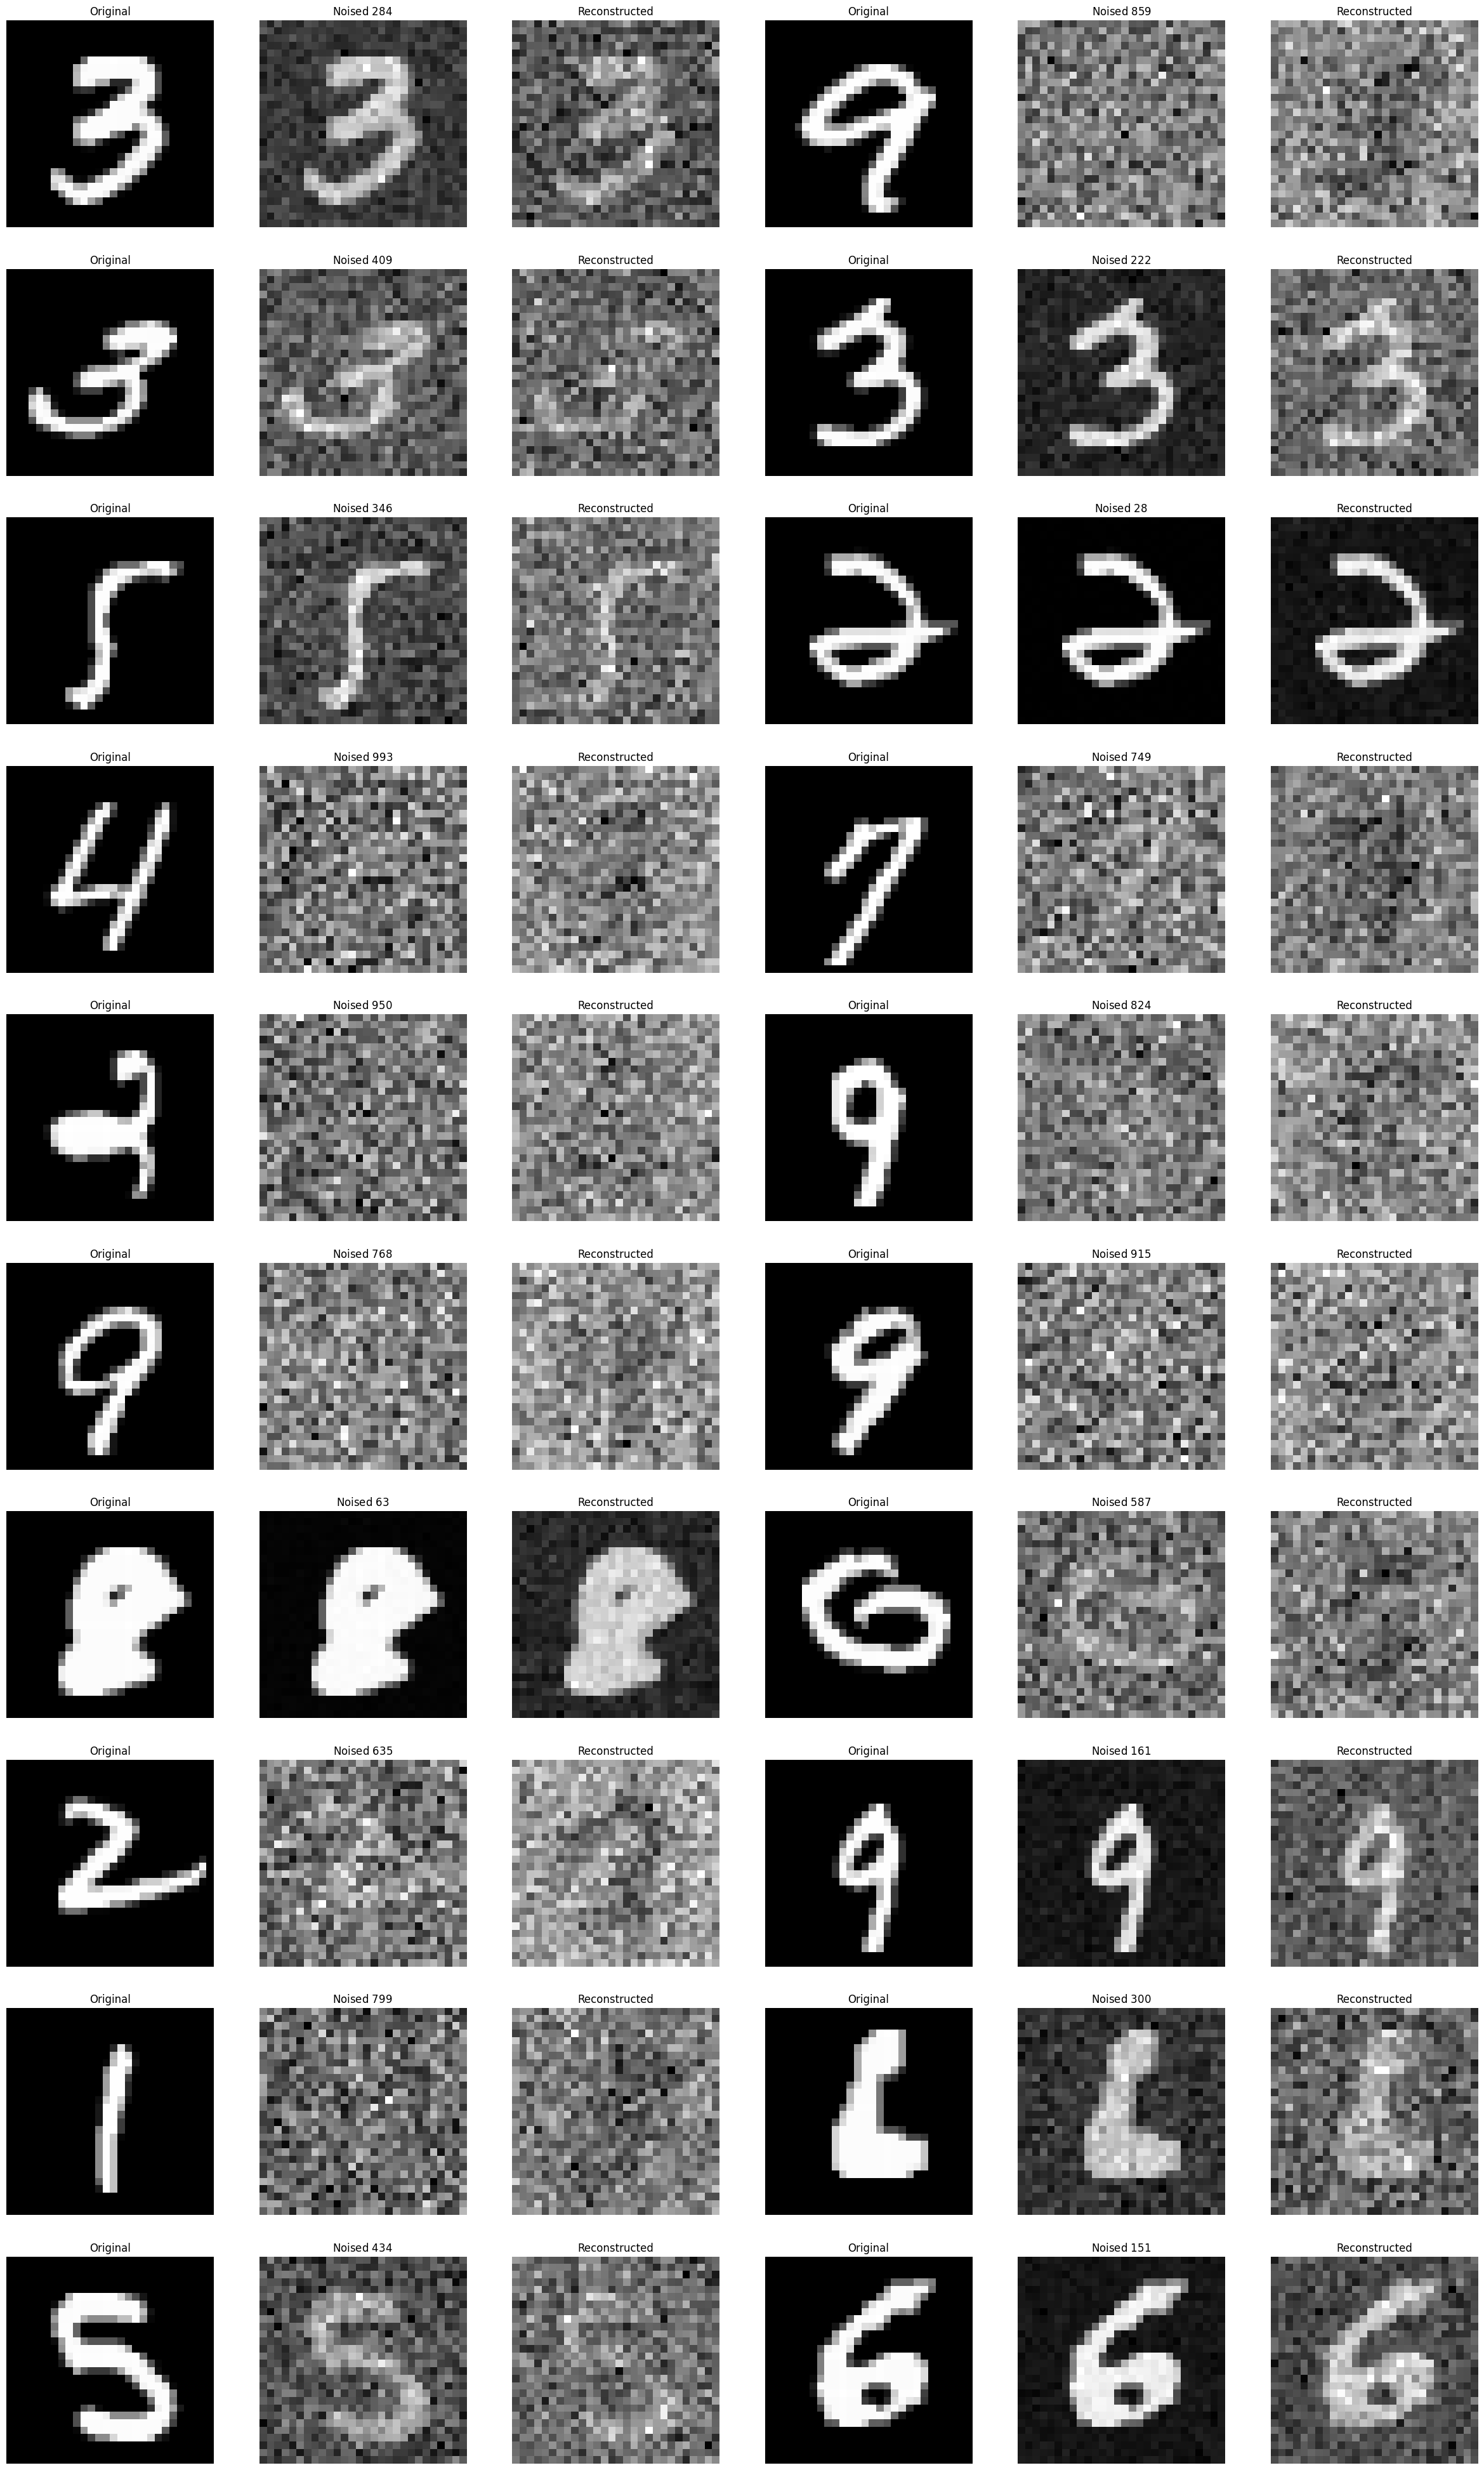

In [13]:
SAMPLES = 20

fig = plt.figure(figsize=(5*6, int(np.ceil(5 * SAMPLES / 2))))
axes = fig.subplots(int(np.ceil(SAMPLES / 2)), 6).flatten()
for ax in axes:
	ax.axis('off')

choice = np.random.choice(X.shape[0], size=SAMPLES, replace=False)
originals = torch.from_numpy(X[choice])
original_labels = torch.from_numpy(y[choice])
noise_steps = torch.from_numpy(np.random.randint(0, STEPS, size=SAMPLES))
noises = denoise_direct(originals, noise_steps)

with torch.no_grad():
	current_step = noise_steps.clone()
	reconstructing = noises.clone()
	for _ in progressbar(range(noise_steps.max().item() + 1)):
		to_walk = torch.argwhere(current_step >= 0).flatten()
		t = current_step[to_walk]
		to_pass = reconstructing[to_walk]
		classes = original_labels[to_walk]
		pred = sd(to_pass, t, classes)
		reconstructing[to_walk] = make_backward_step(to_pass, t, pred)
		current_step[to_walk] -= 1

for i in range(SAMPLES):
	axes[i*3+0].imshow(originals[i].reshape(28, 28), cmap='gray')
	axes[i*3+0].set_title('Original')
	axes[i*3+1].imshow(noises[i].reshape(28, 28), cmap='gray')
	axes[i*3+1].set_title(f'Noised ${noise_steps[i]}$')
	axes[i*3+2].imshow(reconstructing[i].reshape(28, 28), cmap='gray')
	axes[i*3+2].set_title('Reconstructed')